This notebook expects you've already run `lvl2_downloads.ipynb` to get the data and `phat_gaia_match.ipynb` to get the PHAT->Gaia WCS solution

In [138]:
import json
from pathlib import Path

import numpy as np

from scipy import stats

from astropy import units as u
from astropy.wcs import WCS
from astropy.io import fits
from astropy.table import Table, QTable
from astropy.coordinates import SkyCoord
from astropy import visualization as aviz

import jwst.datamodels

import photutils

from IPython import display

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

In [3]:
# supress log10 -> nan warning because we use this as a feature
np.seterr(invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

# Find all the images and create the associated wcses

In [4]:
jwdl = Path('mastDownload/JWST/')
list(list(jwdl.iterdir())[0].iterdir())

[PosixPath('mastDownload/JWST/jw02609001001_02101_00001_nrca1/jw02609001001_02101_00001_nrca1_i2d.fits'),
 PosixPath('mastDownload/JWST/jw02609001001_02101_00001_nrca1/jw02609001001_02101_00001_nrca1_i2d_phatgaiadr3wcs.fits')]

In [5]:
wcspaths = list(jwdl.glob('**/*phatgaiadr3wcs.fits'))
im2dpaths = [Path(str(path).replace('_phatgaiadr3wcs.fits', '.fits')) for path in wcspaths]

In [6]:
wcses = [WCS(fits.getheader(path)) for path in wcspaths]

Set OBSGEO-B to   -26.223612 from OBSGEO-[XYZ].
Set OBSGEO-H to 1598977707.152 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -26.215042 from OBSGEO-[XYZ].
Set OBSGEO-H to 1598854930.920 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -26.213001 from OBSGEO-[XYZ].
Set OBSGEO-H to 1598825695.212 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


# Load the PHAT data

In [7]:
phat_tab = QTable.read('hlsp_phat_hst_wfc3-uvis-acs-wfc-wfc3-ir_12110-m31-b19_f275w-f336w-f475w-f814w-f110w-f160w_v2_st.fits')
phat_tab['coord'] = SkyCoord.guess_from_table(phat_tab, unit='deg')

In [8]:
with open('phat_astrom_correction.json') as f:
    phat_astrom_correction = json.load(f)

phat_tab['coord_corr'] = SkyCoord(
    ra=phat_tab['coord'].ra + phat_astrom_correction['ra_to_add_to_phat_deg']*u.deg, 
    dec=phat_tab['coord'].dec + phat_astrom_correction['dec_to_add_to_phat_deg']*u.deg
)

## First validate MSATA stars, selecting on NIRCam F110W

In [9]:
## E's values from running ETC for M32 catalog (optical filters)
#saturation_limit = 19.2 # according to ETC in F110W with NSRAPID  #vegamag is 19.2 abmag is 19.5
#faint_limit = 23.2 # S/N > 20 in F110W with NSRAPID # vegamag is 23.2 abmag is 23.5
#companion_mag_cutoff = 26

# K's values from running ETC for PHAT catalog
saturation_limit = 19.0 # according to ETC - source mag in vegamag F110W WFC3/IR, strategy: with NSRAPID in F110W
# using JDOX table - this is a more conservative choice
saturation_limit = 19.5 

faint_limit = 22.1 # S/N > 20 according to ETC; vegamag F110W WFC3/IR, with NSRAPID in F110W
# unlike saturation limit, above is approx. the same as the JDOX table, which is 22.0 in F110W NIRSpec
faint_limit_for_mag_contrast = faint_limit + 2  # this *must* be fainter than faint_limit for the code below to work right
companion_mag_cutoff = faint_limit + 10.  # this is for determining what counts when looking for companions within 0.3 arcsec

flux_factor_for_contrast = 10**((faint_limit_for_mag_contrast - faint_limit)/-2.5)



# "gst" field is true for good stars
msata_candidates = phat_tab[(saturation_limit < phat_tab['f110w_vega'])&(phat_tab['f110w_vega'] < faint_limit)&phat_tab['f110w_gst']]
len(msata_candidates)

71896

In [10]:
i2d_img = jwst.datamodels.open(im2dpaths[0])
w = wcses[0]

px, py = w.world_to_pixel(msata_candidates['coord_corr'])
inimg = ((0 < px) & (px < i2d_img.shape[1]) & 
         (0 < py) & (py < i2d_img.shape[0]))

msata_inimg_candidates = msata_candidates[inimg]

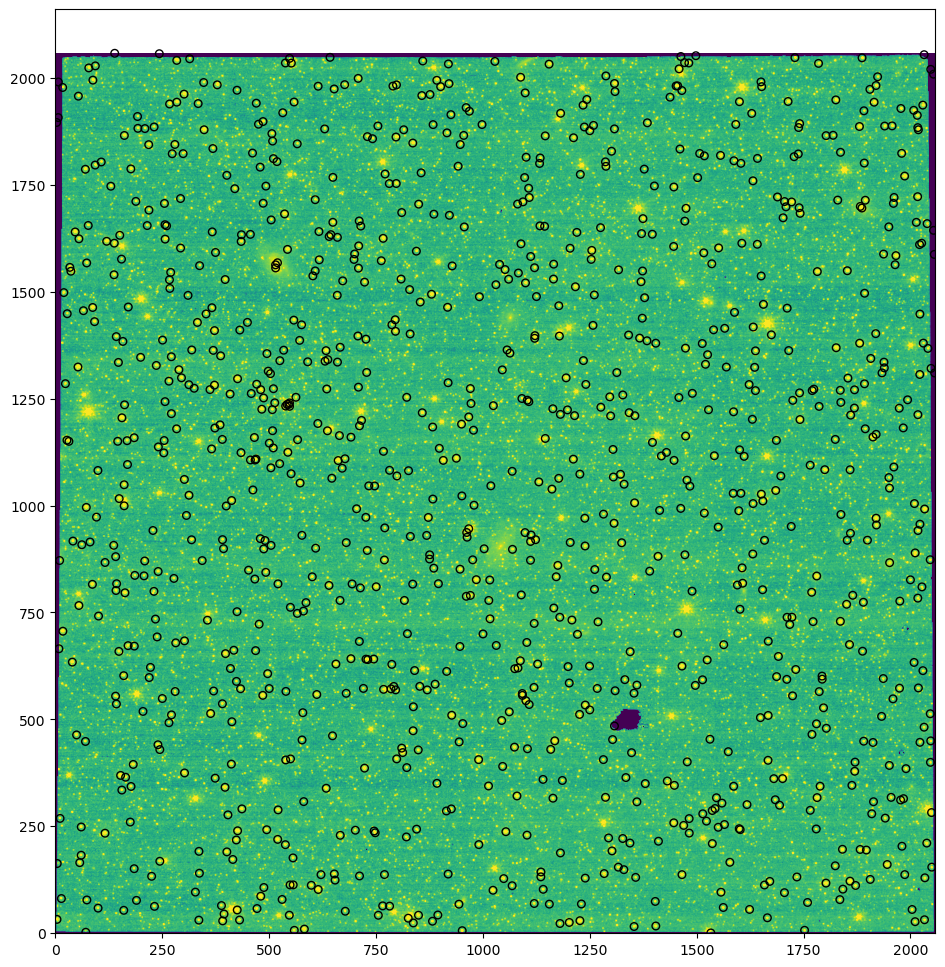

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.set_aspect('equal')

aviz.imshow_norm(i2d_img.data, ax=ax, origin='lower',
                interval=aviz.AsymmetricPercentileInterval(1, 99),
                stretch=aviz.LogStretch())

sc = ax.scatter(px[inimg], py[inimg], s=30, linewidths=1, c='none', edgecolors='black')

In [12]:
sc.remove() # re-use the figure below

In [13]:
bkg = photutils.background.MMMBackground()
bkg_level = bkg(i2d_img.data)
bkg_level

0.32155898213386536

JDox (https://jwst-docs.stsci.edu/jwst-near-infrared-spectrograph/nirspec-observing-strategies/nirspec-msata-reference-star-selection-recommended-strategies#NIRSpecMSATAReferenceStarSelectionRecommendedStrategies-Isolation) says they use 3.2" boxes, so lets try that

In [14]:
aps_bigbox = photutils.SkyRectangularAperture(msata_inimg_candidates['coord_corr'], 3.2*u.arcsec, 3.2*u.arcsec)
paps_bigbox = aps_bigbox.to_pixel(w)
phot_bigbox = photutils.aperture_photometry(i2d_img.data - bkg_level, paps_bigbox)
phot_bigbox['aperture_mag'] = -2.5*np.log10(phot_bigbox['aperture_sum'])

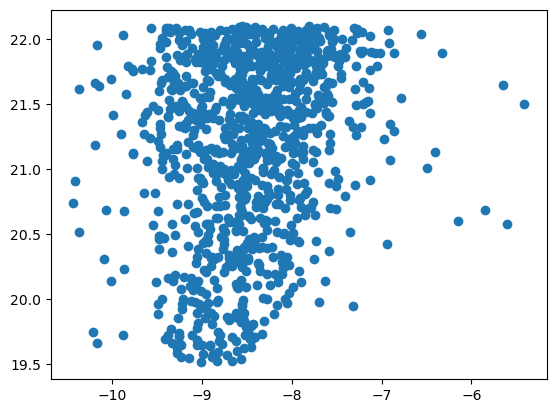

In [15]:
plt.scatter(phot_bigbox['aperture_mag'], msata_inimg_candidates['f110w_vega'])

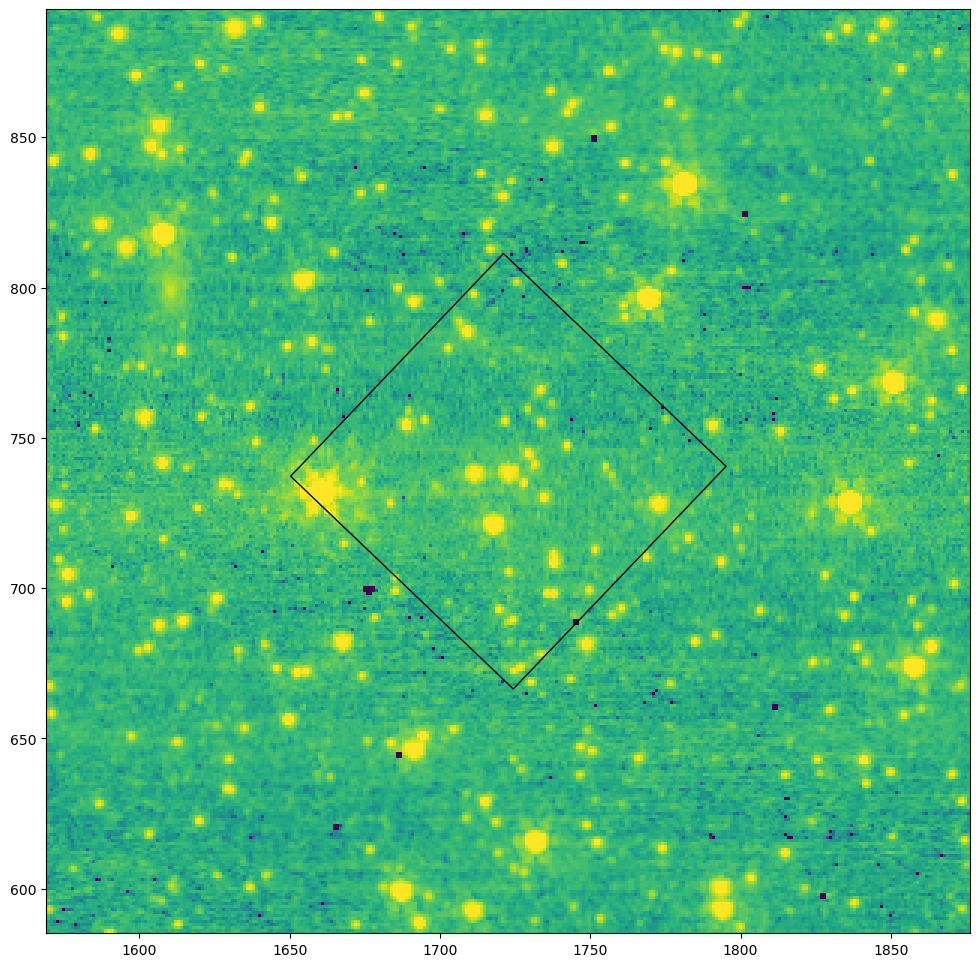

In [16]:
i = np.random.randint(len(paps_bigbox))

try:
    marker.remove()
except NameError:
    pass

p = paps_bigbox[i]
marker = p.plot(ax)[0]

ax.set_xlim(p.positions[0] - p.w*1.5, p.positions[0] + p.w*1.5)
ax.set_ylim(p.positions[1] - p.h*1.5, p.positions[1] + p.h*1.5)

fig

Quite a bit of stuff in the way.  So lets try some smaller apertures and try to derive a COG.

In [17]:
circ_phots = {}

for rad in [.05, .1, .2, .3, .5, .75, 1, 1.5, 2, 3.2]*u.arcsec:
    aps_circ = photutils.SkyCircularAperture(msata_inimg_candidates['coord_corr'], rad)
    paps_circ = aps_circ.to_pixel(w)
    phot_circ = photutils.aperture_photometry(i2d_img.data - bkg_level, paps_circ)
    phot_circ['aperture_mag'] = -2.5*np.log10(phot_circ['aperture_sum'])
    circ_phots[rad] = (paps_circ, phot_circ)

In [18]:
aps_bkg = photutils.SkyCircularAnnulus(msata_inimg_candidates['coord_corr'], r_in=5*u.arcsec, r_out=10*u.arcsec)
paps_bkg = aps_bkg.to_pixel(w)
phot_bkg = photutils.aperture_photometry(i2d_img.data - bkg_level, paps_bkg)
#apstats_bkg = photutils.aperture.ApertureStats(i2d_img.data - bkg_level, paps_bkg)

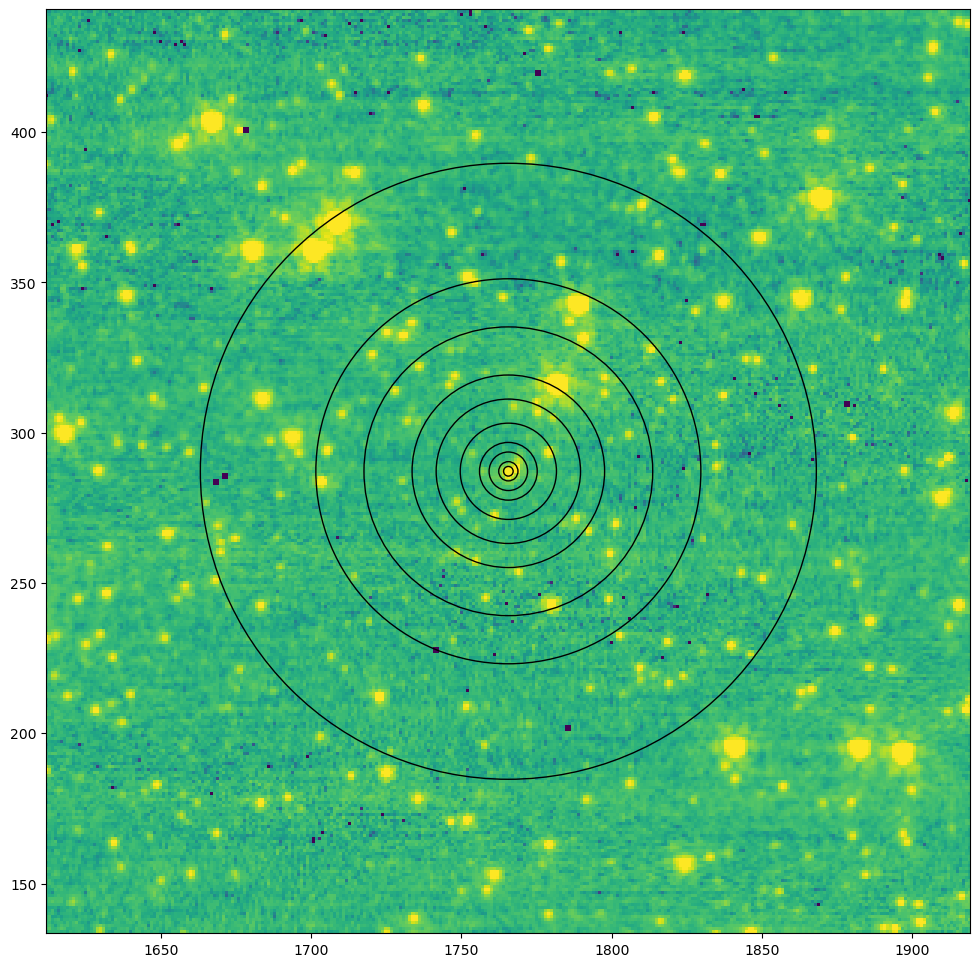

In [19]:
i = np.random.randint(len(msata_inimg_candidates))

try:
    for marker in markers:
        marker.remove()
except NameError:
    pass

rmx = 0
markers = []
rs = []
flux = []
for r, (paps_circ, phot)  in  circ_phots.items():
    p = paps_circ[i]
    markers.append(p.plot(ax)[0])
    if p.r > rmx:
        rmx = p.r
    flux.append(phot['aperture_sum'][i])
    rs.append(r.value)
    

ax.set_xlim(p.positions[0] - rmx*1.5, p.positions[0] + rmx*1.5)
ax.set_ylim(p.positions[1] - rmx*1.5, p.positions[1] + rmx*1.5)
fig

(-10.0, -4.0)

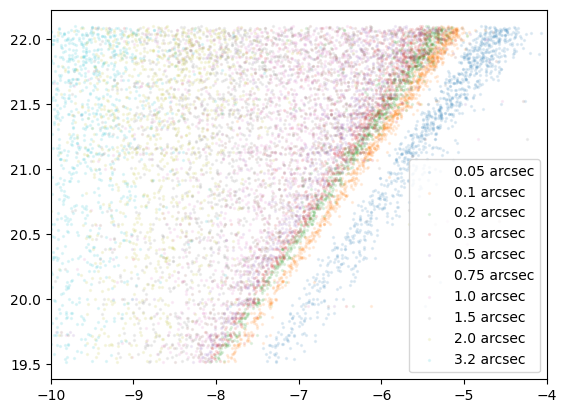

In [20]:
for r, (paps_circ, phot) in circ_phots.items():
    plt.scatter(phot['aperture_mag'], msata_inimg_candidates['f110w_vega'], alpha=.1, s=2, label=str(r))
    
plt.legend(loc=0)
plt.xlim(-10, -4)

(-1.0, 1.0)

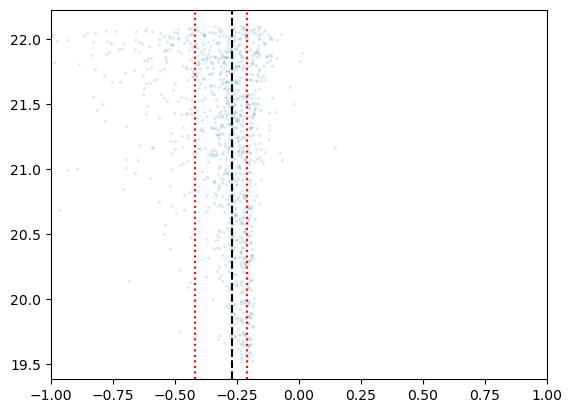

In [21]:
ap_ratio = circ_phots[0.3*u.arcsec][1]['aperture_mag']-circ_phots[0.1*u.arcsec][1]['aperture_mag']
lower, med, upper = np.quantile(ap_ratio[np.isfinite(ap_ratio)], (.2, .5, .8))

plt.scatter(ap_ratio, 
            msata_inimg_candidates['f110w_vega'], alpha=.1, s=2, label=str(r))
plt.axvline(med, c='k', ls='--')
plt.axvline(lower, c='r', ls=':')
plt.axvline(upper, c='r', ls=':')

plt.xlim(-1, 1)

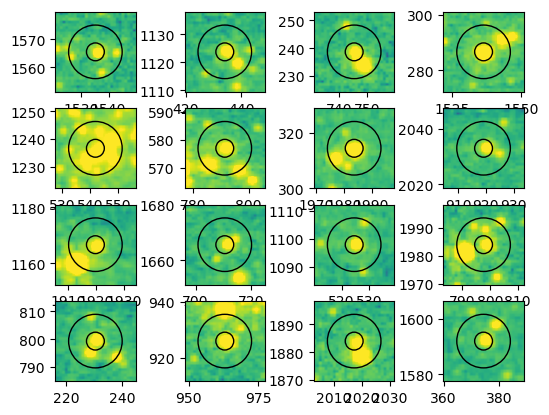

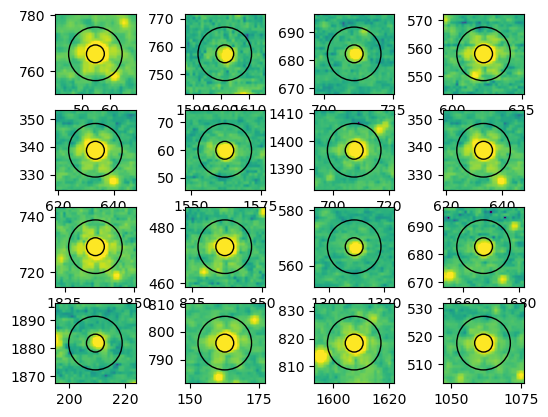

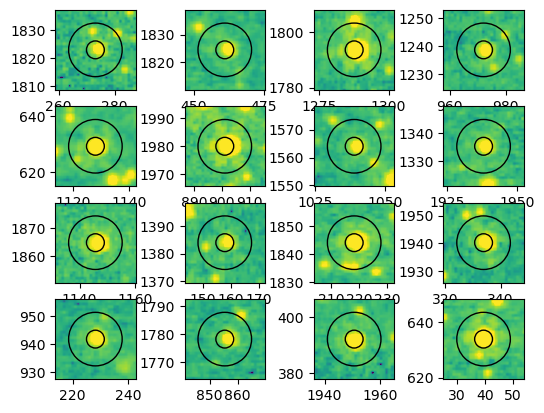

In [22]:
lower_fraction = np.arange(len(ap_ratio))[ap_ratio < lower]
middle_fraction = np.arange(len(ap_ratio))[ap_ratio > upper]
upper_fraction = np.arange(len(ap_ratio))[(lower < ap_ratio)&(ap_ratio < upper)]

for frac in [lower_fraction, middle_fraction, upper_fraction]:
    fig, axs = plt.subplots(4, 4)
    for i, ax in zip(np.random.choice(frac, axs.size), axs.ravel()): 
        aviz.imshow_norm(i2d_img.data, ax=ax, origin='lower',
                interval=aviz.AsymmetricPercentileInterval(1, 99),
                stretch=aviz.LogStretch())

        rmx = 0
        markers = []
        rs = []
        flux = []
        for r, (paps_circ, phot)  in  circ_phots.items():
            if r.value not in [.1, .3]:
                continue
            p = paps_circ[i]
            markers.append(p.plot(ax)[0])
            if p.r > rmx:
                rmx = p.r
            flux.append(phot['aperture_sum'][i])
            rs.append(r.value)


        ax.set_xlim(p.positions[0] - rmx*1.5, p.positions[0] + rmx*1.5)
        ax.set_ylim(p.positions[1] - rmx*1.5, p.positions[1] + rmx*1.5)

The upper 80% seems best. But now lets try with the isolation cuts charlie is using

In [23]:
nircam_tab = QTable.read('m31_nircam_calib.fits.gz')
nircam_tab['coord'] = SkyCoord.guess_from_table(nircam_tab, unit='deg')
# nircam_tab['coord_corr'] = SkyCoord(
#     ra=phat_tab['coord'].ra + phat_astrom_correction['ra_to_add_to_phat_deg']*u.deg, 
#     dec=phat_tab['coord'].dec + phat_astrom_correction['dec_to_add_to_phat_deg']*u.deg
# )

msata_candidates_nc = nircam_tab[(saturation_limit < nircam_tab['f110w'])&(nircam_tab['f110w'] < faint_limit)]
msata_companions_nc = nircam_tab[nircam_tab['f110w'] < companion_mag_cutoff]

In [24]:
_, d2d, _ = msata_candidates_nc['coord'].match_to_catalog_sky(msata_companions_nc['coord'], 2)
no_companions = d2d.arcsec > .3
np.sum(no_companions)/len(no_companions), len(no_companions)

(0.6573595004460303, 11210)

In [25]:
rejects = []
for row in msata_candidates_nc:
    seps = row['coord'].separation(nircam_tab['coord'])
    rejects.append(np.min(nircam_tab['f110w'][seps < 3.2*u.arcsec]) < row['f110w'])

In [26]:
isolated_msata = msata_candidates_nc[~np.array(rejects) & no_companions]
len(isolated_msata)

1288

(-10.0, -4.0)

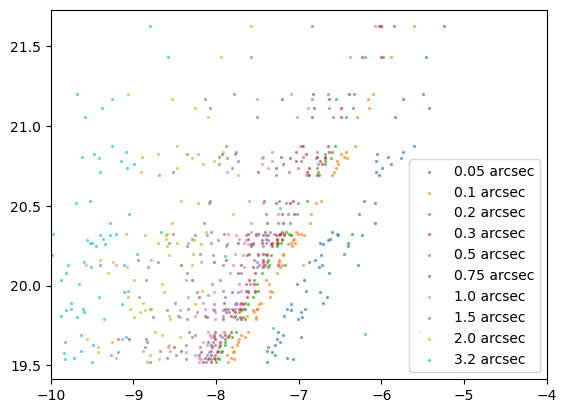

In [27]:
circ_phots = {}

for rad in [.05, .1, .2, .3, .5, .75, 1, 1.5, 2, 3.2]*u.arcsec:
    aps_circ = photutils.SkyCircularAperture(isolated_msata['coord'], rad)
    paps_circ = aps_circ.to_pixel(w)
    phot_circ = photutils.aperture_photometry(i2d_img.data - bkg_level, paps_circ)
    phot_circ['aperture_mag'] = -2.5*np.log10(phot_circ['aperture_sum'])
    circ_phots[rad] = (paps_circ, phot_circ)
    
for r, (paps_circ, phot) in circ_phots.items():
    plt.scatter(phot['aperture_mag'], isolated_msata['f110w'], alpha=.5, s=2, label=str(r))
    
plt.legend(loc=0)
plt.xlim(-10, -4)

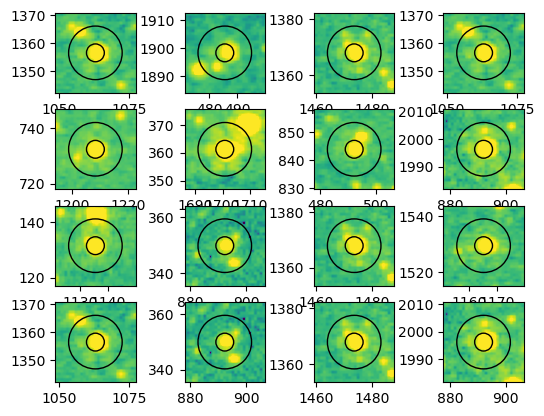

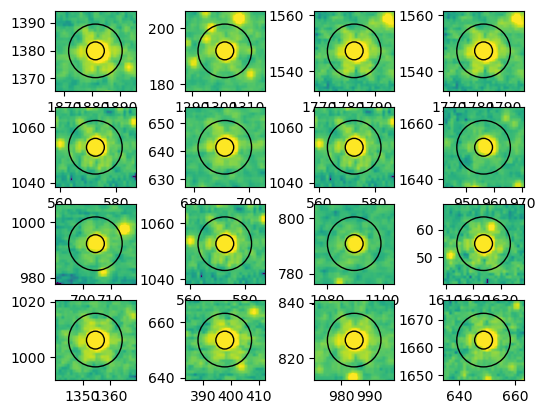

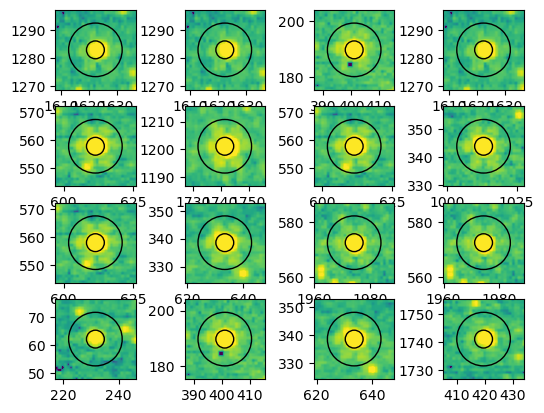

In [28]:
ap_ratio = circ_phots[0.3*u.arcsec][1]['aperture_mag'] - circ_phots[0.1*u.arcsec][1]['aperture_mag']
lower, med, upper = np.quantile(ap_ratio[np.isfinite(ap_ratio)], (.2, .5, .8))

lower_fraction = np.arange(len(ap_ratio))[ap_ratio < lower]
upper_fraction = np.arange(len(ap_ratio))[ap_ratio > upper]
middle_fraction = np.arange(len(ap_ratio))[(lower < ap_ratio)&(ap_ratio < upper)]

for frac in [lower_fraction, middle_fraction, upper_fraction]:
    fig, axs = plt.subplots(4, 4)
    for i, ax in zip(np.random.choice(frac, axs.size), axs.ravel()): 
        aviz.imshow_norm(i2d_img.data, ax=ax, origin='lower',
                interval=aviz.AsymmetricPercentileInterval(1, 99),
                stretch=aviz.LogStretch())

        rmx = 0
        markers = []
        rs = []
        flux = []
        for r, (paps_circ, phot)  in  circ_phots.items():
            if r.value not in [.1, .3]:
                continue
            p = paps_circ[i]
            markers.append(p.plot(ax)[0])
            if p.r > rmx:
                rmx = p.r
            flux.append(phot['aperture_sum'][i])
            rs.append(r.value)


        ax.set_xlim(p.positions[0] - rmx*1.5, p.positions[0] + rmx*1.5)
        ax.set_ylim(p.positions[1] - rmx*1.5, p.positions[1] + rmx*1.5)

## Try yet again but using Charlie's MSATA candidate list

In [29]:
charlie_tab = QTable.read('Targets+MSATA.fits')
charlie_tab['coord'] = SkyCoord.guess_from_table(charlie_tab, unit='deg')

# don't need for lvl2 but do need for any lvl3 comparison
charlie_tab['coord_corr'] = SkyCoord(
    ra=charlie_tab['coord'].ra + phat_astrom_correction['ra_to_add_to_phat_deg']*u.deg, 
    dec=charlie_tab['coord'].dec + phat_astrom_correction['dec_to_add_to_phat_deg']*u.deg
)
charlie_tab['coord_anticorr'] = SkyCoord(
    ra=charlie_tab['coord'].ra - phat_astrom_correction['ra_to_add_to_phat_deg']*u.deg, 
    dec=charlie_tab['coord'].dec - phat_astrom_correction['dec_to_add_to_phat_deg']*u.deg
)

charlie_tab

<QTable length=9943>
  id         asemi        ...             coord_anticorr           
                          ...                deg,deg               
int64       float64       ...                SkyCoord              
------ ------------------ ... -------------------------------------
    29 2.7258543968200684 ...    11.503748768164904,42.113141805633
    32 1.7773030996322632 ...     11.511169268528,42.10784728336479
   128 2.6679725646972656 ... 11.516038764282023,42.104395703492166
   146 2.0342822074890137 ...   11.51490866058042,42.10506336050388
   230  2.090496778488159 ...    11.5199529190259,42.10136364144051
   244 1.8212515115737915 ...  11.516958170178853,42.10337940779854
   ...                ... ...                                   ...
279611 1.8902873992919922 ...  11.567395251898573,42.08588183341061
279635  2.014781951904297 ...    11.56691160217441,42.0853097373383
279741  2.632558822631836 ...  11.564729239047525,42.08469880196118
279810 2.2472012042999268 ...   11.56337191355396,42.08370093327532
279948 1.9926011562347412 ... 11.562160551569116,42.081269325924424
281765 2.3313961029052734 ...  11.593266301204753,42.10464859933661

In [30]:
msata_candidate_charlie_msk = charlie_tab['Weight'] == 1
msata_candidate_charlie = charlie_tab[msata_candidate_charlie_msk]
len(msata_candidate_charlie)

361

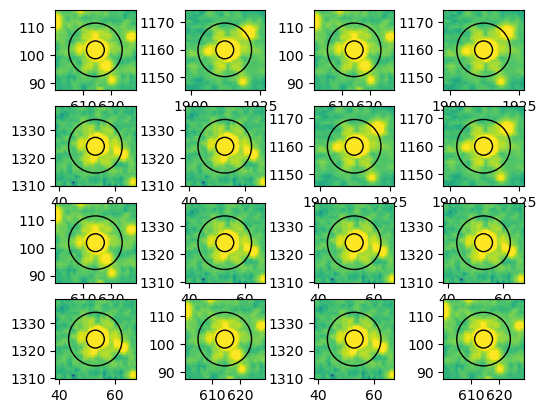

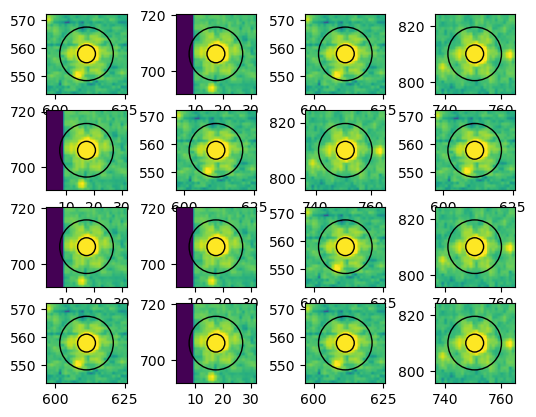

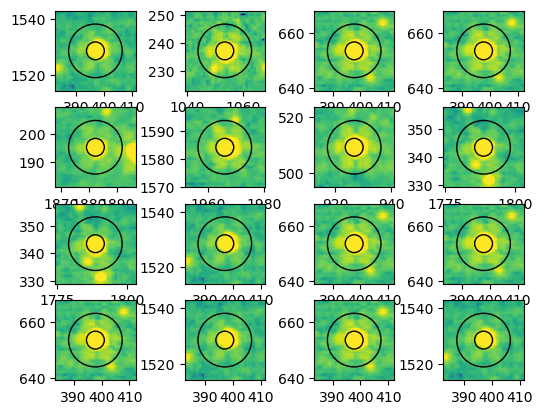

In [31]:
circ_phots = {}

for rad in [.05, .1, .2, .3, .5, .75, 1, 1.5, 2, 3.2]*u.arcsec:
    aps_circ = photutils.SkyCircularAperture(msata_candidate_charlie['coord'], rad)
    paps_circ = aps_circ.to_pixel(w)
    phot_circ = photutils.aperture_photometry(i2d_img.data - bkg_level, paps_circ)
    phot_circ['aperture_mag'] = -2.5*np.log10(phot_circ['aperture_sum'])
    circ_phots[rad] = (paps_circ, phot_circ)
    
    
ap_ratio = circ_phots[0.3*u.arcsec][1]['aperture_mag'] - circ_phots[0.1*u.arcsec][1]['aperture_mag']
lower, med, upper = np.quantile(ap_ratio[np.isfinite(ap_ratio)], (.2, .5, .8))

lower_fraction = np.arange(len(ap_ratio))[ap_ratio < lower]
middle_fraction = np.arange(len(ap_ratio))[ap_ratio > upper]
upper_fraction = np.arange(len(ap_ratio))[(lower < ap_ratio)&(ap_ratio < upper)]

for frac in [lower_fraction, middle_fraction, upper_fraction]:
    fig, axs = plt.subplots(4, 4)
    for i, ax in zip(np.random.choice(frac, axs.size), axs.ravel()): 
        aviz.imshow_norm(i2d_img.data, ax=ax, origin='lower',
                interval=aviz.AsymmetricPercentileInterval(1, 99),
                stretch=aviz.LogStretch())

        rmx = 0
        markers = []
        rs = []
        flux = []
        for r, (paps_circ, phot)  in  circ_phots.items():
            if r.value not in [.1, .3]:
                continue
            p = paps_circ[i]
            markers.append(p.plot(ax)[0])
            if p.r > rmx:
                rmx = p.r
            flux.append(phot['aperture_sum'][i])
            rs.append(r.value)


        ax.set_xlim(p.positions[0] - rmx*1.5, p.positions[0] + rmx*1.5)
        ax.set_ylim(p.positions[1] - rmx*1.5, p.positions[1] + rmx*1.5)

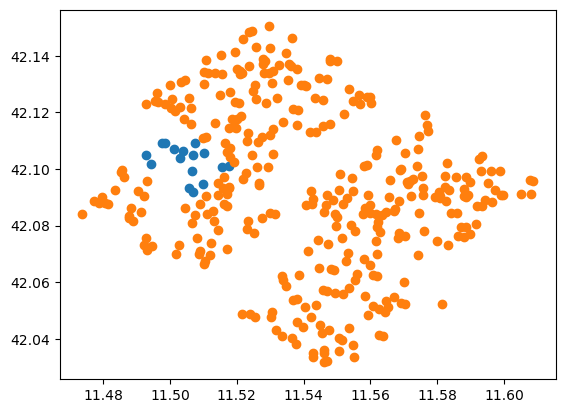

In [32]:
inside = msata_candidate_charlie[np.isfinite(ap_ratio)]
outside = msata_candidate_charlie[~np.isfinite(ap_ratio)]
plt.scatter(inside['ra'], inside['dec'])
plt.scatter(outside['ra'], outside['dec'])

So the end goal: loop over all the lvl2 images, compute the .1" to .3" ratio, and remove a particular percentile.  Note the loop below could be parallelized for speed or memory efficiency if needed.

In [33]:
# 1 means reject, 0 means dont reject, -1 means not in field
rejects = {}

for path in im2dpaths:
    with jwst.datamodels.open(path) as im:
        if im.meta.instrument.filter != 'F150W':
            print('skipping', path, 'because not F150W')
            continue
            
        bkg_level = bkg(im.data)
            
        circ_phots = {}

        for rad in [.1, .3]*u.arcsec:
            aps_circ = photutils.SkyCircularAperture(msata_candidate_charlie['coord'], rad)
            paps_circ = aps_circ.to_pixel(im.meta.wcs)
            phot_circ = photutils.aperture_photometry(im.data - bkg_level, paps_circ)
            phot_circ['aperture_mag'] = -2.5*np.log10(phot_circ['aperture_sum'])
            circ_phots[rad] = (paps_circ, phot_circ)


        ap_ratio = circ_phots[0.3*u.arcsec][1]['aperture_mag'] - circ_phots[0.1*u.arcsec][1]['aperture_mag']
        in_field = np.isfinite(ap_ratio)
        lower, med, upper = np.quantile(ap_ratio[in_field], (.2, .5, .8))

        lower_fraction = np.arange(len(ap_ratio))[ap_ratio < lower]
        upper_fraction = np.arange(len(ap_ratio))[ap_ratio > upper]
        middle_fraction = np.arange(len(ap_ratio))[(lower < ap_ratio)&(ap_ratio < upper)]
            
        rejects[path.stem] = reject = -np.ones(len(in_field), dtype=int)
        reject[middle_fraction] = 0
        reject[upper_fraction] = 1
        reject[lower_fraction] = 1
reject_vals = np.array(list(rejects.values()))

skipping mastDownload/JWST/jw02609001001_02101_00001_nrcalong/jw02609001001_02101_00001_nrcalong_i2d.fits because not F150W
skipping mastDownload/JWST/jw02609001001_02101_00001_nrcblong/jw02609001001_02101_00001_nrcblong_i2d.fits because not F150W
skipping mastDownload/JWST/jw02609001002_02101_00001_nrcalong/jw02609001002_02101_00001_nrcalong_i2d.fits because not F150W
skipping mastDownload/JWST/jw02609001002_02101_00001_nrcblong/jw02609001002_02101_00001_nrcblong_i2d.fits because not F150W
skipping mastDownload/JWST/jw02609001002_02101_00002_nrcalong/jw02609001002_02101_00002_nrcalong_i2d.fits because not F150W
skipping mastDownload/JWST/jw02609001002_02101_00002_nrcblong/jw02609001002_02101_00002_nrcblong_i2d.fits because not F150W


In [34]:
np.bincount(np.sum(reject_vals==0, axis=0))  # this is how many are 0, which means how many are good

array([141, 178,  42])

In [35]:
keep_msata_col = -np.ones_like(charlie_tab['id'])
keep_msata_col[msata_candidate_charlie_msk] = np.sum(reject_vals==0, axis=0) 

charlie_tab['keep_msata_apphot'] = keep_msata_col

#charlie_tab.write('Targets+MSATAwmsata_apphot.fits')

# Targets in slits

In [173]:
slit_pa = 227.8859197*u.deg
slit_w = .46*u.arcsec
slit_h = .2*u.arcsec

In [174]:
targets_charlie_msk = charlie_tab['Weight'] > 1
sci_targets = charlie_tab[targets_charlie_msk]
len(sci_targets)

9582

In [175]:
aps_slit = photutils.SkyRectangularAperture(sci_targets['coord'], slit_w, slit_h, slit_pa)
paps_slit = aps_slit.to_pixel(w)
phot_slit = photutils.aperture_photometry(i2d_img.data - bkg_level, paps_slit)
phot_slit['aperture_mag'] = -2.5*np.log10(phot_slit['aperture_sum'])

In [176]:
circ_phots = {}
for rad in [.05, .1, .2, .3, .5, .75, 1]*u.arcsec:
    aps_circ = photutils.SkyCircularAperture(sci_targets['coord'], rad)
    paps_circ = aps_circ.to_pixel(w)
    phot_circ = photutils.aperture_photometry(i2d_img.data - bkg_level, paps_circ)
    phot_circ['aperture_mag'] = -2.5*np.log10(phot_circ['aperture_sum'])
    circ_phots[rad] = (paps_circ, phot_circ)

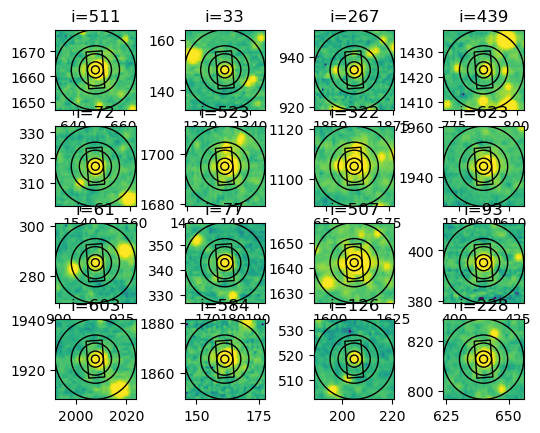

In [177]:
fig, axs = plt.subplots(4, 4)

done = set()
for ax in axs.ravel(): 
    i = None
    while i is None:
        i = np.random.randint(len(sci_targets))
        if not np.isfinite(phot_slit['aperture_mag'][i]):
            i = None
        if i in done:
            i = None
    done.add(i)


    aviz.imshow_norm(i2d_img.data, ax=ax, origin='lower',
            interval=aviz.AsymmetricPercentileInterval(1, 99),
            stretch=aviz.LogStretch())

    paps_slit[i].plot(ax)

    rmx = 0
    markers = []
    rs = []
    flux = []
    for r, (paps_circ, phot)  in  circ_phots.items():
        p = paps_circ[i]
        markers.append(p.plot(ax)[0])
        if p.r > rmx:
            rmx = p.r
        flux.append(phot['aperture_sum'][i])
        rs.append(r.value)


    ax.set_xlim(p.positions[0] - rmx*.5, p.positions[0] + rmx*.5)
    ax.set_ylim(p.positions[1] - rmx*.5, p.positions[1] + rmx*.5)
    ax.set_title(f'i={i}')

(-29.0, -26.0)

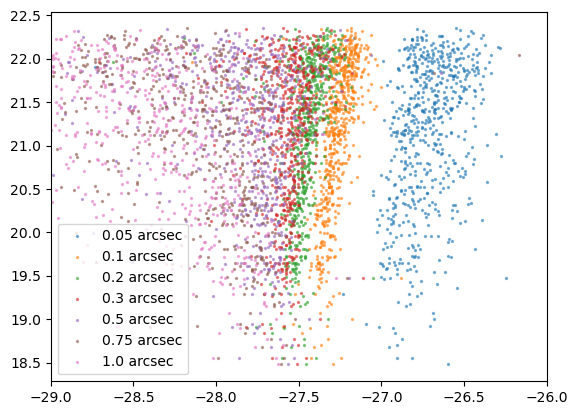

In [178]:
  
for r, (paps_circ, phot) in circ_phots.items():
    plt.scatter(phot['aperture_mag'] - sci_targets['f110w'], sci_targets['f110w'], alpha=.5, s=2, label=str(r))
    
plt.legend(loc=0)
plt.xlim(-29, -26)

(-0.4, 0.1)

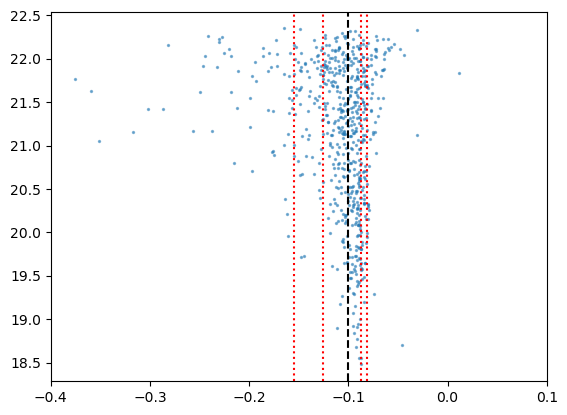

In [179]:
ap_ratio = phot_slit['aperture_mag'] - circ_phots[0.1*u.arcsec][1]['aperture_mag']
med = np.quantile(ap_ratio[np.isfinite(ap_ratio)], .5)
qtiles = np.quantile(ap_ratio[np.isfinite(ap_ratio)], (.1, .2, .8, .9))

plt.scatter(ap_ratio, 
            sci_targets['f110w'], alpha=.5, s=2, label=str(r))
plt.axvline(med, c='k', ls='--')
for qt in qtiles:
    plt.axvline(qt, c='r', ls=':')

plt.xlim(-.4, .1)

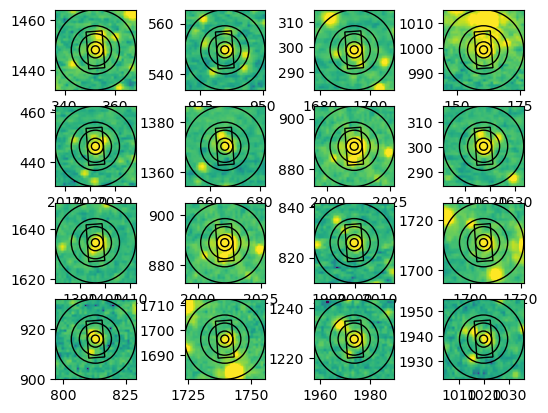

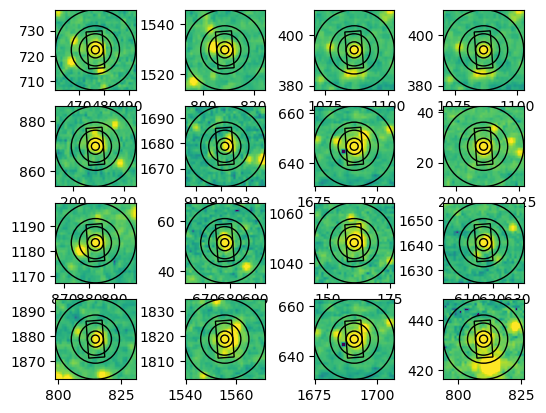

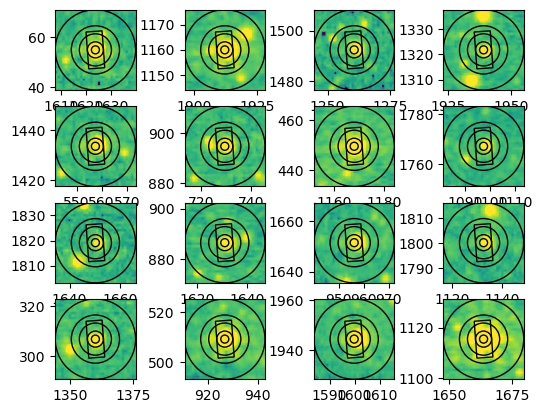

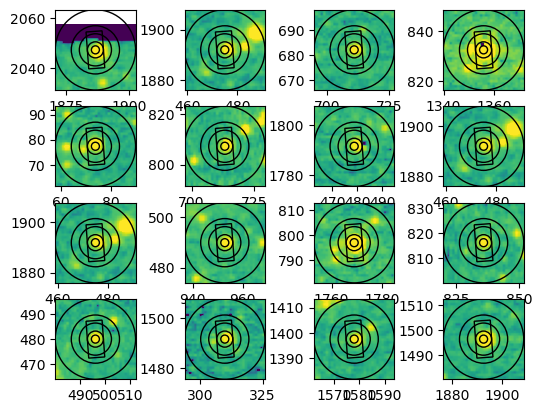

In [180]:
lower, semilower, med, upper = np.quantile(ap_ratio[np.isfinite(ap_ratio)], (.1, .2, .5, .9))

lower_fraction = np.arange(len(ap_ratio))[ap_ratio < lower]
semilower_fraction = np.arange(len(ap_ratio))[(ap_ratio > lower) & (ap_ratio < semilower)]
upper_fraction = np.arange(len(ap_ratio))[ap_ratio > upper]
middle_fraction = np.arange(len(ap_ratio))[(semilower < ap_ratio)&(ap_ratio < upper)]

for frac in [lower_fraction, semilower_fraction, middle_fraction, upper_fraction]:
    fig, axs = plt.subplots(4, 4)
    for i, ax in zip(np.random.choice(frac, axs.size), axs.ravel()): 
        aviz.imshow_norm(i2d_img.data, ax=ax, origin='lower',
                interval=aviz.AsymmetricPercentileInterval(1, 99),
                stretch=aviz.LogStretch())

        paps_slit[i].plot(ax)

        rmx = 0
        markers = []
        rs = []
        flux = []
        for r, (paps_circ, phot)  in  circ_phots.items():
            p = paps_circ[i]
            markers.append(p.plot(ax)[0])
            if p.r > rmx:
                rmx = p.r
            flux.append(phot['aperture_sum'][i])
            rs.append(r.value)


        ax.set_xlim(p.positions[0] - rmx*.5, p.positions[0] + rmx*.5)
        ax.set_ylim(p.positions[1] - rmx*.5, p.positions[1] + rmx*.5)

10% should definitely reject, 10-20% questionable.

In [181]:
# 1 means reject, 0 means dont reject, -1 means not in field
rejects = {}

for path in im2dpaths:
    with jwst.datamodels.open(path) as im:
        if im.meta.instrument.filter != 'F150W':
            print('skipping', path, 'because not F150W')
            continue
            
        bkg_level = bkg(im.data)
        
        aps_slit = photutils.SkyRectangularAperture(sci_targets['coord'], slit_w, slit_h, slit_pa)
        paps_slit = aps_slit.to_pixel(im.meta.wcs)
        phot_slit = photutils.aperture_photometry(i2d_img.data - bkg_level, paps_slit)
        phot_slit['aperture_mag'] = -2.5*np.log10(phot_slit['aperture_sum'])
            
        circ_phots = {}

        for rad in [.1]*u.arcsec:
            aps_circ = photutils.SkyCircularAperture(sci_targets['coord'], rad)
            paps_circ = aps_circ.to_pixel(im.meta.wcs)
            phot_circ = photutils.aperture_photometry(im.data - bkg_level, paps_circ)
            phot_circ['aperture_mag'] = -2.5*np.log10(phot_circ['aperture_sum'])
            circ_phots[rad] = (paps_circ, phot_circ)

        ap_ratio = phot_slit['aperture_mag'] - circ_phots[0.1*u.arcsec][1]['aperture_mag']
        in_field = np.isfinite(ap_ratio)
        reject_line = np.quantile(ap_ratio[in_field], .1)

        toreject = np.arange(len(ap_ratio))[ap_ratio < reject_line]
            
        rejects[path.stem] = reject = -np.ones(len(in_field), dtype=int)
        reject[in_field] = 0
        reject[toreject] = 1
reject_vals = np.array(list(rejects.values()))

skipping mastDownload/JWST/jw02609001001_02101_00001_nrcalong/jw02609001001_02101_00001_nrcalong_i2d.fits because not F150W
skipping mastDownload/JWST/jw02609001001_02101_00001_nrcblong/jw02609001001_02101_00001_nrcblong_i2d.fits because not F150W
skipping mastDownload/JWST/jw02609001002_02101_00001_nrcalong/jw02609001002_02101_00001_nrcalong_i2d.fits because not F150W
skipping mastDownload/JWST/jw02609001002_02101_00001_nrcblong/jw02609001002_02101_00001_nrcblong_i2d.fits because not F150W
skipping mastDownload/JWST/jw02609001002_02101_00002_nrcalong/jw02609001002_02101_00002_nrcalong_i2d.fits because not F150W
skipping mastDownload/JWST/jw02609001002_02101_00002_nrcblong/jw02609001002_02101_00002_nrcblong_i2d.fits because not F150W


In [182]:
keep_sci_col = -np.ones_like(charlie_tab['id'])
keep_sci_col[targets_charlie_msk] = np.sum(reject_vals==0, axis=0) 

charlie_tab['keep_sci_apphot'] = keep_sci_col

charlie_tab.write('Targets+MSATAwtarget_apphot.fits', overwrite=True)

In [183]:
np.bincount(charlie_tab['keep_sci_apphot']+1)  # first is "not in field", second is "no field accepts it", and the others are "at least one field is happy with it"

array([ 361, 3535, 4907, 1140])

In [184]:
l3im = jwst.datamodels.open('MAST_2022-08-24T1111/JWST/jw02609-o001_t006_nircam_clear-f150w/jw02609-o001_t006_nircam_clear-f150w_i2d.fits')

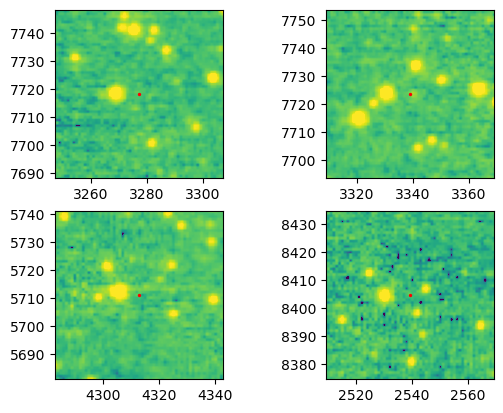

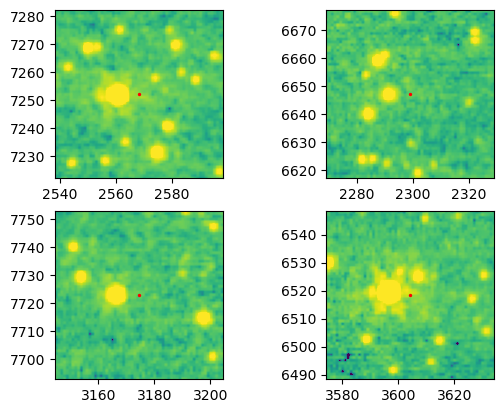

In [185]:
for tset in [charlie_tab[charlie_tab['keep_sci_apphot']==0], charlie_tab[charlie_tab['keep_sci_apphot']>0]]:
    fig, axs = plt.subplots(2, 2)
    for i, ax in zip(np.random.choice(frac, axs.size, replace=False), axs.ravel()): 
        aviz.imshow_norm(l3im.data, ax=ax, origin='lower',
                interval=aviz.AsymmetricPercentileInterval(1, 99),
                stretch=aviz.LogStretch())

        px, py = l3im.meta.wcs.world_to_pixel(tset['coord'][i])
        ax.scatter([px], [py], c='r', s=2)
        ax.set_xlim(px-30, px+30)
        ax.set_ylim(py-30, py+30)

After some discussion, reconsidered to instead do a priority thing of doing 5x the priority for things in the 10 region, and 20x for things in the 10% region

In [186]:
# 1 means reject, 0 means dont reject, -1 means not in field
quantiles = {}

for path in im2dpaths:
    with jwst.datamodels.open(path) as im:
        if im.meta.instrument.filter != 'F150W':
            print('skipping', path, 'because not F150W')
            continue
            
        bkg_level = bkg(im.data)
        
        aps_slit = photutils.SkyRectangularAperture(sci_targets['coord'], slit_w, slit_h, slit_pa)
        paps_slit = aps_slit.to_pixel(im.meta.wcs)
        phot_slit = photutils.aperture_photometry(i2d_img.data - bkg_level, paps_slit)
        phot_slit['aperture_mag'] = -2.5*np.log10(phot_slit['aperture_sum'])
            
        circ_phots = {}

        for rad in [.1]*u.arcsec:
            aps_circ = photutils.SkyCircularAperture(sci_targets['coord'], rad)
            paps_circ = aps_circ.to_pixel(im.meta.wcs)
            phot_circ = photutils.aperture_photometry(im.data - bkg_level, paps_circ)
            phot_circ['aperture_mag'] = -2.5*np.log10(phot_circ['aperture_sum'])
            circ_phots[rad] = (paps_circ, phot_circ)

        ap_ratio = phot_slit['aperture_mag'] - circ_phots[0.1*u.arcsec][1]['aperture_mag']
        in_field = np.isfinite(ap_ratio)
        
        quantiles[path.stem] = qs = -np.ones(len(in_field), dtype=float)
        qs[in_field] = stats.percentileofscore(ap_ratio[in_field], ap_ratio[in_field])/100.   
        
quantilesa = np.array(list(quantiles.values()))

skipping mastDownload/JWST/jw02609001001_02101_00001_nrcalong/jw02609001001_02101_00001_nrcalong_i2d.fits because not F150W
skipping mastDownload/JWST/jw02609001001_02101_00001_nrcblong/jw02609001001_02101_00001_nrcblong_i2d.fits because not F150W
skipping mastDownload/JWST/jw02609001002_02101_00001_nrcalong/jw02609001002_02101_00001_nrcalong_i2d.fits because not F150W
skipping mastDownload/JWST/jw02609001002_02101_00001_nrcblong/jw02609001002_02101_00001_nrcblong_i2d.fits because not F150W
skipping mastDownload/JWST/jw02609001002_02101_00002_nrcalong/jw02609001002_02101_00002_nrcalong_i2d.fits because not F150W
skipping mastDownload/JWST/jw02609001002_02101_00002_nrcblong/jw02609001002_02101_00002_nrcblong_i2d.fits because not F150W


In [187]:
overlaps = quantilesa[:, np.sum(quantilesa>0, axis=0)==2]  #<- some overlap.  Do they agree on the metric?
np.bincount(np.sum((overlaps>.2), axis=0))

array([ 65, 400, 932])

mostly agree?

In [188]:
qs_flat = np.mean(quantilesa, where=quantilesa>0, axis=0)

2022-11-07 18:36:34,852 - stpipe - WARNING - /usr/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,



In [270]:
rescale = np.ones(len(charlie_tab), dtype=float)

bad = (qs_flat>0)&(qs_flat<.1)
maybebad = (qs_flat>.1)&(qs_flat<.2)

rescale[np.where(targets_charlie_msk)[0][bad]] = 1/20
rescale[np.where(targets_charlie_msk)[0][maybebad]] = 1/5

try:
    charlie_tab.remove_column('keep_sci_apphot')
except KeyError:
    pass # in case you got back and re-compute
charlie_tab['new_Weight'] = (charlie_tab['Weight'] * rescale).astype(int)

charlie_tab.write('Targets+MSATAwapphot_weighting.fits', overwrite=True)

np.unique(charlie_tab['new_Weight'])

<Column name='new_Weight' dtype='int64' length=7>
   1
   5
  20
  50
 100
 200
1000

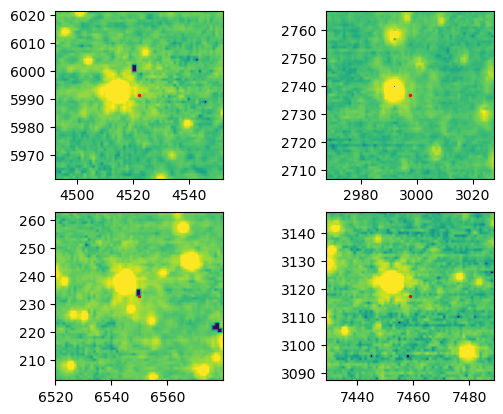

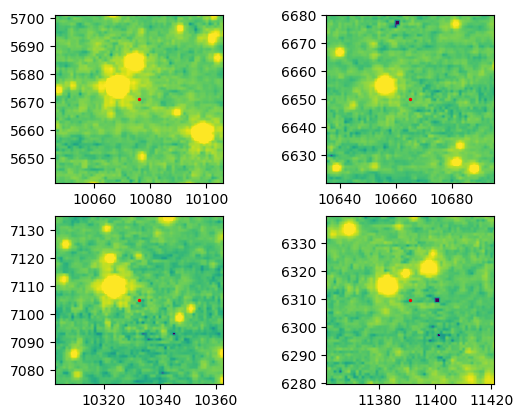

In [256]:
for tset in [charlie_tab[charlie_tab['new_Weight']==1000], charlie_tab[charlie_tab['new_Weight']==50]]:
    fig, axs = plt.subplots(2, 2)
    for i, ax in zip(np.random.choice(len(tset), axs.size, replace=False), axs.ravel()): 
        aviz.imshow_norm(l3im.data, ax=ax, origin='lower',
                interval=aviz.AsymmetricPercentileInterval(1, 99),
                stretch=aviz.LogStretch())

        px, py = l3im.meta.wcs.world_to_pixel(tset['coord'][i])
        ax.scatter([px], [py], c='r', s=2)
        ax.set_xlim(px-30, px+30)
        ax.set_ylim(py-30, py+30)

Slit convention test:

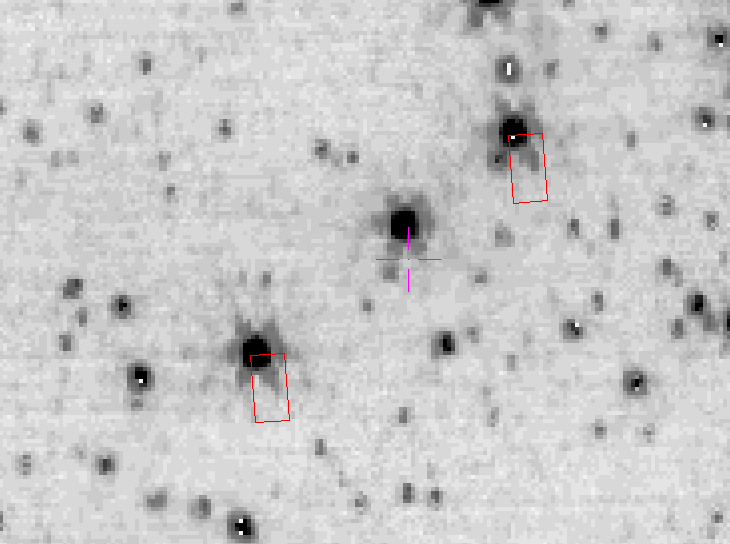

In [190]:
display.Image(filename='charlie_msa_screenshot.png')

For above: IDs are 164165 and 163598 (from the id column of the of the target catalog). Ra and dec of the center of the image are 00:46:09.37 +42:06:57.4

skipping mastDownload/JWST/jw02609001001_02101_00001_nrcalong/jw02609001001_02101_00001_nrcalong_i2d.fits because not F150W
skipping mastDownload/JWST/jw02609001001_02101_00001_nrcblong/jw02609001001_02101_00001_nrcblong_i2d.fits because not F150W
skipping mastDownload/JWST/jw02609001002_02101_00001_nrcalong/jw02609001002_02101_00001_nrcalong_i2d.fits because not F150W
skipping mastDownload/JWST/jw02609001002_02101_00001_nrcblong/jw02609001002_02101_00001_nrcblong_i2d.fits because not F150W
skipping mastDownload/JWST/jw02609001002_02101_00002_nrcalong/jw02609001002_02101_00002_nrcalong_i2d.fits because not F150W
skipping mastDownload/JWST/jw02609001002_02101_00002_nrcblong/jw02609001002_02101_00002_nrcblong_i2d.fits because not F150W


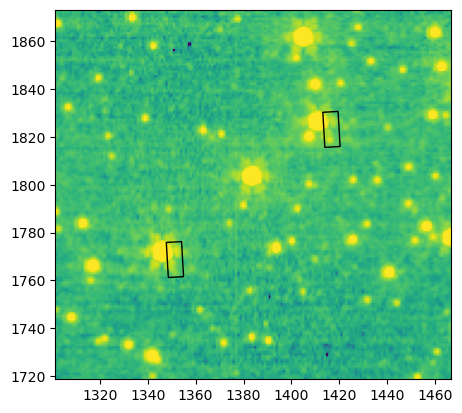

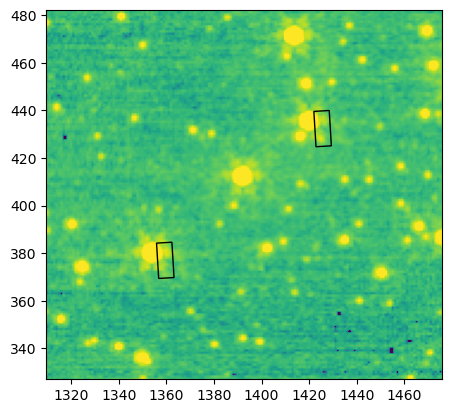

In [191]:
tmsk = np.in1d(charlie_tab['id'], [164165, 163598])

for path in im2dpaths:
    with jwst.datamodels.open(path) as im:
        if im.meta.instrument.filter != 'F150W':
            print('skipping', path, 'because not F150W')
            continue
            
        aps_slit = photutils.SkyRectangularAperture(charlie_tab['coord'][tmsk], slit_w, slit_h, slit_pa)
        paps_slit = aps_slit.to_pixel(im.meta.wcs)
        phot_slit = photutils.aperture_photometry(im.data, paps_slit)
        phot_slit['aperture_mag'] = -2.5*np.log10(phot_slit['aperture_sum'])
        
        if np.any(np.isfinite(phot_slit['aperture_mag'])):
            plt.figure()
            aviz.imshow_norm(im.data, origin='lower',
                interval=aviz.AsymmetricPercentileInterval(1, 99),
                stretch=aviz.LogStretch())
            paps_slit.plot()
            xmi, ymi = np.min(paps_slit.positions, axis=0)
            xmx, ymx = np.max(paps_slit.positions, axis=0)
            plt.xlim(xmi - 50, xmx + 50)
            plt.ylim(ymi - 50, ymx + 50)